In [1]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from scipy import sparse

from setup_networks import network_from_txt, network_indices, Network, triangular_lattice_pts, get_edges, network_from_edges_and_nodes
from currents import * 
from adaptation import adaptation_ode, ss_solve
from measures import steady_state_dissipation, area_penalty, cost
from phase_diagrams import get_sinks, remove_edges, make_ellipse_netw, netw_to_nx

In [8]:
ellipse_ratio = 1.0
insertion_point_str = 'center'

N_nodes = 10000
edge_len = 0.08
N_kappas = 10;
N_rhos = 10;
num_replicates = 10;

kappas = np.logspace(-3, 0, N_kappas)
rhos = np.logspace(0, 2, N_rhos)

In [47]:
'''
Given a Network object and a ratio of the two ellipse axes (1.0 if circle), returns
the square root of the area of the network.
'''
def sqrt_area_of_network(netw, ellipse_ratio):
    inds = network_indices(netw)
    left_idx = inds['left']
    dist_fn = lambda x: np.linalg.norm(x[left_idx] - x, axis=1)
    dists = dist_fn(netw.pos)
    long_axis = np.max(dists) / 2
    short_axis = long_axis*ellipse_ratio
    return np.sqrt(np.pi * long_axis * short_axis)

'''
Arguments:
    - netw: Network object
    - K: list of conductances for each edge in the network
    - insertion_point: string ('center' or 'left') indicating the position of the source in the network
Returns: 
    - unweighted_path_length: list of lengths of shortest paths from the source to each branch point in the network, 
        where the length is measured in the number of nodes
    - path_length: list of lengths of shortest paths from the source to each branch point in the network, 
        where the length is measured in the number of nodes and paths are weighted by 1/conductance
    - path_weight: list of lengths of shortest paths from the source to each branch point in the network, 
        where the length is measured in 1/conductance and paths are weighted by 1/conductance
'''
def distance_insertion_to_branch_points(netw, K, insertion_point='center'):
    clipped_netw, clipped_K = remove_edges(netw, K)
    G = netw_to_nx(clipped_netw, clipped_K)
    
    inds = network_indices(clipped_netw)
    source = inds[insertion_point]
    
    degrees = np.array(list(G.degree))
    branch_points = np.where(degrees[:, 1] > 2)[0]
    
    unweighted_path_length = []
    path_length = []
    path_weight = []
    for b in branch_points:
        path = nx.dijkstra_path(G, source, b, weight='K')
        pathweight = nx.path_weight(G, path, weight='K')
        path_unweighted = nx.dijkstra_path(G, source, b, weight=1.)
        
        path_length += [len(path)-1] #subtract 1 to get number of edges rather than number of nodes in path
        unweighted_path_length += [len(path_unweighted) - 1]
        path_weight += [pathweight]
        
        
    return np.array(unweighted_path_length, dtype=float), np.array(path_length, dtype=float), np.array(path_weight, dtype=float)

In [ ]:
# Make two arrays:
# n_kappas x n_rhos
# n_kappas x n_rhos x 

In [41]:
def rebuild_netw(N_nodes, edge_len, ellipse_ratio):
    nodes = triangular_lattice_pts(N_nodes, edge_len)
    edges = get_edges(nodes)
    netw_ = network_from_edges_and_nodes(edges, nodes)
    netw = make_ellipse_netw(netw_, 0.5, 0.5)
    netw = make_ellipse_netw(netw, 1.0, ellipse_ratio)
    return netw

FileNotFoundError: ../data/expgrowth_el1.0_ipcenter/Ks/K_kappa0.001_rho1.6681005372000588_replicate0.txt not found.

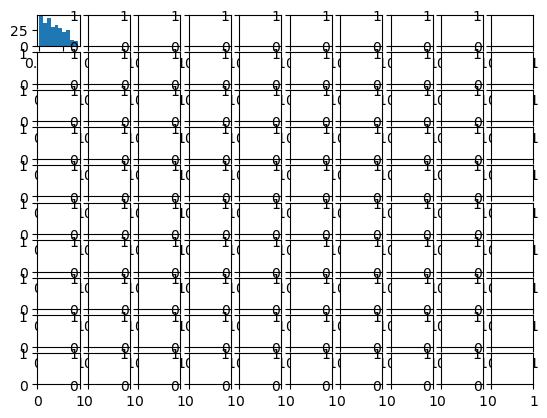

In [48]:
fig, axs = plt.subplots(N_kappas, N_rhos)
min_dist_to_branch_pt = np.zeros((N_kappas, N_rhos))

netw = rebuild_netw(N_nodes, edge_len, ellipse_ratio)
sqrt_area = sqrt_area_of_network(netw, ellipse_ratio)
filepath = f'../data/expgrowth_el{ellipse_ratio}_ip{insertion_point_str}/Ks/K_'

for kk in range(len(kappas)):
    k = kappas[kk]
    for pp in range(len(rhos)):
        p = rhos[pp]
        filename_ = filepath + f'kappa{k}_rho{p}'
        
        
        min_dists = 0
        path_lens = []
        for r in range(num_replicates):
            filename = filename_ + f'_replicate{r}.txt'
            K = np.loadtxt(filename)
            
            # compute lists of shortest path lenghts from source to branch points
            unweighted_path_lengths, path_lengths, path_weights = distance_insertion_to_branch_points(netw, K, insertion_point='center')
            
             #normalize the lengths 
            path_lengths *= edge_len / sqrt_area
            unweighted_path_lengths *= edge_len / sqrt_area
            
            min_dists += np.sort(path_lengths)[1]
            path_lens.extend(list(path_lengths))
            
        min_dist_to_branch_pt[kk, pp] = min_dists/num_replicates
        axs[kk, pp].hist(path_lens)
            
            
            
            
            

In [49]:
np.loadtxt('../data/expgrowth_el1.0_ipcenter/Ks/K_kappa0.001_rho1.6681005372*')

FileNotFoundError: ../data/expgrowth_el1.0_ipcenter/Ks/K_kappa0.001_rho1.6681005372* not found.

In [50]:
import os
directory = os.fsencode('../data/expgrowth_el1.0_ipcenter/Ks/')
for f in os.listdir(directory):
    K = np.loadtxt(f)

In [56]:
import re
def extract_number(f):
    s = re.findall("\d+$",f)
    print(s)
    return (s[0] if s else -1,f)

In [60]:
re.split('(\d+)', filename)

['../data/expgrowth_el',
 '1',
 '.',
 '0',
 '_ipcenter/Ks/K_kappa',
 '0',
 '.',
 '001',
 '_rho',
 '1',
 '.',
 '6681005372000588',
 '_replicate',
 '0',
 '.txt']

In [ ]:
filename

In [58]:
extract_number([filename])

TypeError: expected string or bytes-like object